Note: There might be a handful of bugs at the moment. The developers of this stable diffusion implementation keep changing the api. Everyone should know not to make breaking api changes so regularly! I'll do a pass over the code and fix bugs as soon as I can. Am away this week :) thanks to Michael d for bringing this to my attention. 

# Stable Diffusion Initialisation

In [1]:
# !pip install transformers diffusers lpips 

In [2]:
with open("scratch/token.txt") as f:
    token = f.read().strip()

In [3]:
from typing import Any, List
from pathlib import Path
import json

import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms
import numpy as np

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

/home/jerome/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [4]:
# Using torchvision.transforms.ToTensor
to_tensor_tfm = tfms.ToTensor()

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
    latent = vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
  return 0.18215 * latent.mode() # or .mean or .sample

def latents_to_pil(latents):
    
  # batch of latents -> list of images
  latents = (1 / 0.18215) * latents
    
  with torch.no_grad():
    image = vae.decode(latents)[0]
    
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

# potentially list of str needed?

def prep_text(
    prompt: str,
    tokenizer: Any,
    max_length: int = None
):
    max_length = max_length or tokenizer.model_max_length
    
    if isinstance(prompt, str):
        prompt = [prompt]
    
    # Prep text 
    text_input = tokenizer(
        prompt, 
        padding="max_length", 
        max_length=tokenizer.model_max_length, 
        truncation=True, 
        return_tensors="pt",
    )

    with torch.no_grad():
      text_embeddings = text_encoder(
          text_input.input_ids.to(torch_device)
      )[0]

    max_length = text_input.input_ids.shape[-1]
    return text_embeddings, max_length


def generate_image(
    text_embeddings, # tensor?
    loading_bar=True,
    batch_size=1,
    generator=None,
    guidance_scale=7.5,
    num_inference_steps=50,    
    height=512,
    width=768,
    latents=None
    
):
    if generator is None:
        generator = torch.manual_seed(42)
    
    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)
        
    # Prep latents
    if latents is None:
        latents = torch.randn(
            (
                batch_size, 
                unet.in_channels, 
                height // 8, 
                width // 8
            ),
            generator=generator,
        )

    latents = latents.to(torch_device)
    latents = latents * scheduler.sigmas[0] # Need to scale to match k
    
    loading_bar_function = tqdm if loading_bar else lambda x: x

    # Loop
    with autocast("cuda"):
        for i, t in loading_bar_function(enumerate(scheduler.timesteps)):

            # expand the latents if we are doing classifier-free guidance 
            # to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(
                    latent_model_input, 
                    t, 
                    encoder_hidden_states=text_embeddings,
                )["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

    return latents_to_pil(latents)[0]

def get_output_dir(base: Path):
    base.mkdir(exist_ok=True, parents=True)
    index = max(map(lambda p: int(p.stem), base.glob("[0-9]*")), default=0) + 1
    interp_output = base / str(index)
    interp_output.mkdir()
    return interp_output

In [5]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=token)

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=token)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.self_attn.q_proj.weight', 'vision_model.encoder.layers.4.layer_norm1.bias', 'vision_model.encoder.layers.2.layer_norm2.weight', 'vision_model.encoder.layers.2.layer_norm1.bias', 'vision_model.encoder.layers.22.self_attn.q_proj.weight', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.12.self_attn.out_proj.bias', 'vision_model.encoder.layers.18.self_attn.out_proj.bias', 'vision_model.encoder.layers.4.self_attn.k_proj.bias', 'vision_model.encoder.layers.12.layer_norm2.weight', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.16.layer_norm1.weight', 'vision_model.encoder.layers.11.self_attn.v_proj.weight', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'v

# Inference

In [6]:
output_dir = "outputs/"

0it [00:00, ?it/s]

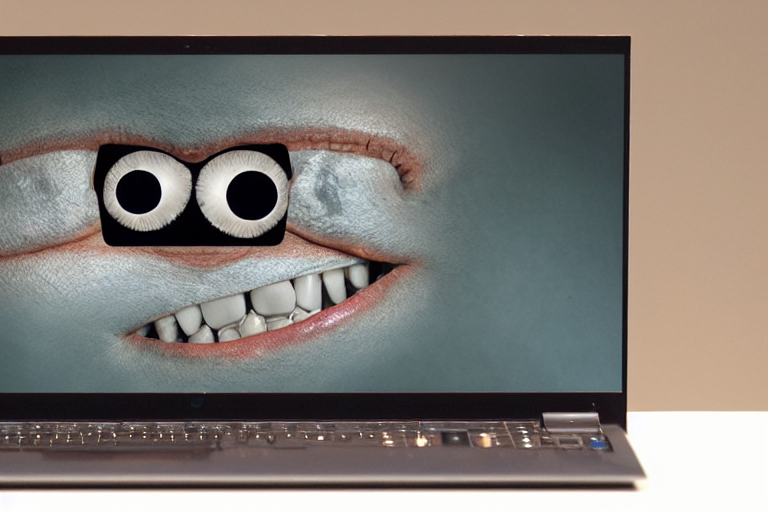

In [10]:
prompt = [
#     "ancient village with small huts, two men with spears talking"
    "a laptop with teeth and eyes"
]
height = 512
width = 768
num_inference_steps = 50
guidance_scale = 7.5
generator = torch.manual_seed(42)
batch_size = 1


text_embeddings, max_length = prep_text(prompt, tokenizer)
uncond_embeddings, _ = prep_text([""], tokenizer)


text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

generate_image(
    text_embeddings,
    height=height,
    width=width,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=generator,
    batch_size=batch_size,
)

# Concept interpolation

## Two step

In [92]:
current_output_dir = get_output_dir(Path(output_dir) / "interp")
# current_output_dir = Path(output_dir) / "interp" / "4"


prompt_1 = [
    "ancient village with small huts, two men with spears talking"
]
prompt_2 = [
    "futuristic city, flying cars, city lights, busy street, 4k, photograph of the year"
]
height = 512
width = 768
num_inference_steps = 50
guidance_scale = 7.5
generator = torch.manual_seed(42)
batch_size = 1

images = []


text_embeddings_1, max_length = prep_text(prompt_1, tokenizer)
text_embeddings_2, max_length = prep_text(prompt_2, tokenizer)

delta = text_embeddings_2 - text_embeddings_1

for i, fraction in tqdm(enumerate(np.linspace(0, 1))):

    text_embeddings_combined = text_embeddings_1 + delta*fraction

    uncond_embeddings, _ = prep_text([""], tokenizer)
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings_combined])

    im = generate_image(
        text_embeddings,
        loading_bar=False,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=torch.manual_seed(42),
        batch_size=batch_size,
    )
    images.append(im)
    im.save(current_output_dir / f"image_{i}.png")

0it [00:00, ?it/s]

/home/jerome/miniconda3/envs/ldm/lib/python3.8/site-packages/diffusers/schedulers/scheduling_lms_discrete.py:207: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(


## N step

In [6]:
from pydantic import BaseModel

In [7]:
class NStepConfig(BaseModel):
    prompts: List[str]
    n_interp_steps: int = 60
        
class _Step(BaseModel):
    origin_image_prompt: str
    origin_image_index: int
    target_image_prompt: str
    target_image_index: int
    file_name: str
    fraction: float
        
class NStepSnapshotConfig(BaseModel):
    config: NStepConfig
    steps: List[_Step]

In [8]:
current_output_dir = get_output_dir(Path(output_dir) / "interp_n_steps")

factor = 1
height = int(512*factor)
width = int(768*factor)
num_inference_steps = 50
guidance_scale = 7.5
get_generator = lambda: torch.manual_seed(43)
batch_size = 1

config = NStepConfig(
    n_interp_steps=60,
    prompts=[
        "Vladimir Putin",
        "Donald Trump",
        "A baby in a suit",
        "Vladimir Putin",
    ],
)

embeddings = [
    prep_text([prompt], tokenizer)[0]
    for prompt in config.prompts
]

deltas = [
    embeddings[i+1] - embeddings[i]
    for i in range(len(embeddings) - 1)
]

# scout
print("scouting")

for i, e in enumerate(embeddings):
    (current_output_dir / "scout").mkdir(exist_ok=True)
    
    uncond_embeddings, _ = prep_text([""], tokenizer)
    e = torch.cat([uncond_embeddings, e])
    
    generate_image(
        e,
        loading_bar=True,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=get_generator(),
        batch_size=batch_size,
    ).save(current_output_dir / "scout" / f"{i}.png")

print("scouting - complete")

tmp = [
    (i, frac )
    for i in range(len(config.prompts) - 1)
    for frac in np.linspace(0, 1, config.n_interp_steps)
]

steps = [
    _Step(
        origin_image_index=i,
        origin_image_prompt=config.prompts[i],
        target_image_index=i+1,
        target_image_prompt=config.prompts[i+1],
        fraction=frac,
        file_name=f"image_{c:05d}_{i+frac:.5}.png",
    )
    for c, (i, frac) in enumerate(tmp)
]

snapshot_config = NStepSnapshotConfig(config=config, steps=steps)

with open(current_output_dir / "config.json", "w") as f:
    f.write(snapshot_config.json(indent=4))

    
for step in tqdm(steps):
    fn = current_output_dir / step.file_name
    if fn.exists():
        continue
    
    text_embeddings_1 = embeddings[step.origin_image_index]
    delta = deltas[step.origin_image_index]
    text_embeddings_combined = text_embeddings_1 + delta*step.fraction

    uncond_embeddings, _ = prep_text([""], tokenizer)
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings_combined])

    im = generate_image(
        text_embeddings,
        loading_bar=False,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=get_generator(),
        batch_size=batch_size,
    )
    im.save(current_output_dir / step.file_name)

scouting


0it [00:00, ?it/s]

MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_30.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package
/home/jerome/miniconda3/envs/ldm/lib/python3.8/site-packages/diffusers/schedulers/scheduling_lms_discrete.py:207: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

scouting - complete


  0%|          | 0/180 [00:00<?, ?it/s]

# Variable embedding step

In [79]:
current_output_dir = get_output_dir(Path(output_dir) / "interp_variable_step")


prompt_1 = [
    "ancient village with small huts, two men with spears talking"
]
prompt_2 = [
    "futuristic city, flying cars, city lights, busy street, 4k, photograph of the year"
]
height = 512 // 2
width = 768 // 2
num_inference_steps = 50
guidance_scale = 7.5
generator = torch.manual_seed(42)
batch_size = 1

images = []


text_embeddings_1, max_length = prep_text(prompt_1, tokenizer)
text_embeddings_2, max_length = prep_text(prompt_2, tokenizer)

delta = text_embeddings_2 - text_embeddings_1

for i, fraction in tqdm(enumerate(np.linspace(0, 1))):

    text_embeddings_combined = text_embeddings_1 + delta*fraction

    uncond_embeddings, _ = prep_text([""], tokenizer)
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings_combined])

    current_im = generate_image(
        text_embeddings,
        loading_bar=False,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=torch.manual_seed(42),
        batch_size=batch_size,
    )
    current_im.save(interp_output / f"image_{i}.png")
    
    if i>2:
        break
    
    prev_im = current_im

0it [00:00, ?it/s]

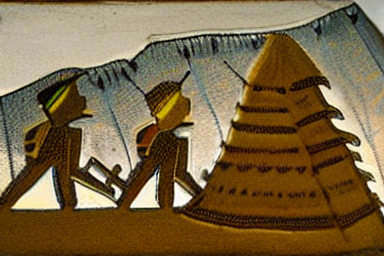

In [80]:
current_im

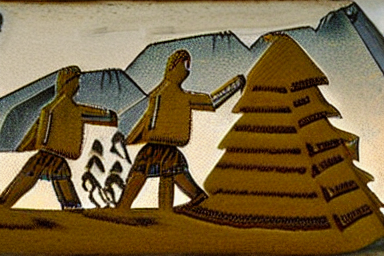

In [81]:
prev_im

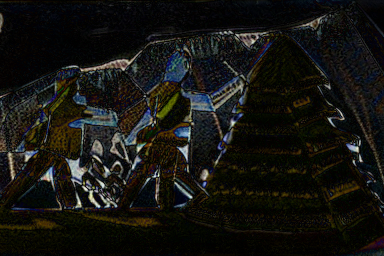

In [90]:
from PIL import Image, ImageChops

diff = ImageChops.difference(prev_im, current_im)
diff

In [104]:
data = diff.getdata()
data.

# Noise Latent Pertubation

In [ ]:
## TODO fix this!
# current_output_dir = get_output_dir(Path(output_dir) / "interp_latent")
current_output_dir = Path(output_dir) / "interp_latent" / "12"


prompt = [
    "alien city"
]
height = 512
width = 768
num_inference_steps = 50
guidance_scale = 7.5
generator = torch.manual_seed(42)
batch_size = 1

n_points_interp = 180

latents_list = [
    torch.randn(
        (
            batch_size, 
            unet.in_channels, 
            height // 8, 
            width // 8
        ),
        generator=torch.manual_seed(i),
    )
    for i in [1, 57, 139]
]
latents_list += [latents_list[0]]

steps = [
    (i, frac)
    for i in range(len(latents_list) - 1)
    for frac in np.linspace(0, 1, n_points_interp)
]

text_embeddings_orig, max_length = prep_text(prompt, tokenizer)
uncond_embeddings, _ = prep_text([""], tokenizer)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings_orig])


for c, (i, fraction) in tqdm(list(enumerate(steps))):
    # current_output_dir / f"image_{c:05d}.png"
    im_file = current_output_dir / f"image_{c}.png"
    if im_file.exists():
        continue
    
    latents_1 = latents_list[i]
    latents_2 = latents_list[i+1]
    
    delta = latents_2 - latents_1
    latents = latents_1 + delta*fraction
    latents -= latents.mean()
    latents /= latents.std()
    im = generate_image(
        text_embeddings,
        latents=latents,
        loading_bar=False,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        batch_size=batch_size,
    )
    im.save(im_file)


  0%|          | 0/540 [00:00<?, ?it/s]

MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_30.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package
/home/jerome/miniconda3/envs/ldm/lib/python3.8/site-packages/diffusers/schedulers/scheduling_lms_discrete.py:207: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(


# Scheduling and Visualisation

In [ ]:
im = Image.open('/content/drive/MyDrive/stablediff/shitake3.png').convert('RGB')
im = im.resize((512,512))
encoded = pil_to_latent(im)
im

# Image to Image

In [ ]:
# Make a folder to store results
!rm -rf /content/drive/MyDrive/stablediff/noise2
!mkdir -p /content/drive/MyDrive/stablediff/noise2

# View a noised version
noise = torch.randn_like(encoded) # Random noise

for i in tqdm(range(200)):
    timestep = i * 5
    encoded_and_noised = scheduler.add_noise(encoded, noise, timestep)
    img = latents_to_pil(encoded_and_noised)[0]
    img.save(f'/content/drive/MyDrive/stablediff/noise/{i:04}.jpeg')

!ffmpeg -v 1 -y -f image2 -framerate 12 -i /content/drive/MyDrive/stablediff/noise/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


In [ ]:
prompt = ["wooden carving of a rabbit eating a leaf, highly detailed, 4k, artisan"]
height = 512                       
width = 512                        
num_inference_steps = 50   
guidance_scale = 8            
generator = torch.manual_seed(1)   
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Start step
start_step = 25
start_sigma = scheduler.sigmas[start_step]
start_timestep = int(scheduler.timesteps[start_step])

# Prep latents
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, start_timestep)
latents = latents.to(torch_device)
latents = latents * start_sigma  # << NB

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i > start_step:
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

# Mixed guidance

In [ ]:
prompts = ['blue fire', 'reticulated python in a tree']
weights = [0.5,0.5]
height = 512                
width = 768                      
num_inference_steps = 50 
guidance_scale = 8 
generator = torch.manual_seed(5)
batch_size = 1

# Prep text 
# Embed both prompts
text_embeddings = []
for i in range(len(prompts)):
    text_input = tokenizer([prompts[i]], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings.append(text_encoder(text_input.input_ids.to(torch_device))[0])

# Take the average
weighted_embeddings = torch.zeros(text_embeddings[0].shape).to(torch_device)

with torch.no_grad():
    for i in range(len(prompts)):
        weighted_embeddings.add_(text_embeddings[i] * weights[i])

text_embeddings = weighted_embeddings

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

# Denoising Example

In [ ]:
prompt = 'a futuristic city, abandoned and overgrown with plants, dystopia, bathed in sunlight'
height = 512                     
width = 768 
num_inference_steps = 100 
guidance_scale = 8     
generator = torch.manual_seed(10) 
batch_size = 1

# Make a folder to store results
!rm -rf /content/drive/MyDrive/stablediff/denoising2/
!mkdir -p /content/drive/MyDrive/stablediff/denoising2/

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    
    im_input = latents_to_pil(latents)[0]

    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred

    im_t0 = latents_to_pil(latents_x0)[0]
    im_noise = latents_to_pil(sigma * noise_pred)[0]

    # And the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (2304, 512))
    im.paste(im_input, (0, 0))
    im.paste(im_noise, (768, 0))
    im.paste(im_t0, (1536, 0))
    im.save(f'/content/drive/MyDrive/stablediff/denoising2/{i:04}.jpg')

In [ ]:
!ffmpeg -v 1 -y -f image2 -framerate 12 -i /content/drive/MyDrive/stablediff/denoising2/%04d.jpg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1536 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)